<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/Double_Pendulum_NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Double Pendulum Simulator

Solving the Euler Lagrange equations for the double pendulum gives the second order differential equations:

$$ \begin{align} \ddot{\theta}_1 & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \dot{\theta}_1^2 \cos{(\theta_1 - \theta_2)} + \dot{\theta}_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \ddot{\theta}_2 & = \frac{2 \left[ \dot{\theta}_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \dot{\theta}_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$

Note that we have set mass and length of both sections to be 1. We need a system of first order differential equations. Thus, we will define $ \omega = \dot{\theta} $ for each section, thus giving us the system of equations:

$$ \begin{align} \frac{d \omega_1}{dt} & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \omega_1^2 \cos{(\theta_1 - \theta_2)} + \omega_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \frac{d \omega_2}{dt} & = \frac{2 \left[ \omega_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \omega_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$
 Plus the simpler equations:
 $$\begin{align} \frac{d \theta_1}{dt} & = \omega_1 \\ \frac{d \theta_2}{dt} & = \omega_2. \end{align} $$

#Generate the Data

In [2]:
!pip install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-w6hnnbqw
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-w6hnnbqw
  Resolved https://github.com/deepmind/dm-haiku to commit 1d543772ba601afe8172fbc4cc47be4f46989102
  Preparing metadata (setup.py) ... done


In [3]:
from typing import Iterator, NamedTuple
import jax
import jax.numpy as jnp
from jax.numpy import pi, sin, cos
from jax import value_and_grad, jit
from jax import random
from jax.experimental.ode import odeint
from jax.config import config
import matplotlib.pyplot as plt
import imageio
import time
from tqdm.auto import trange
from matplotlib.patches import Circle
from functools import partial
from sklearn.model_selection import train_test_split
import haiku as hk
import optax
import numpy as np

# This tells us whether we are on cpu or gpu.
print(jax.lib.xla_bridge.get_backend().platform)

# Disabling jit can be used for debugging. False is the standard.
config.update("jax_disable_jit", False)
# Sometimes NaNs can be generated if we are not working in x64, but x64 is slower. Default is false.
config.update("jax_enable_x64", False)
# This causes the program to end if a NaN is detected in the jax code. Default is False.
config.update("jax_debug_nans", False)

# Define our constants.
g = - 9.81
dt = 0.01
data_points = 32768
prediction_batch_size = 16
training_batch_size = 8
total_time = data_points * dt
gradient_updates = 20000

cpu


In [4]:
""" Define our target differential equation. This will be used to generate our data """

@jit
def dy_dt(y, t, g):
  # These our our 2 angles and 2 angular velocities.
  theta_1 = y[0]
  theta_2 = y[1]
  omega_1 = y[2]
  omega_2 = y[3]

  # Make the equations nicer by setting these:
  s = sin(theta_1 - theta_2)
  c = cos(theta_1 - theta_2)

  # Derivative of the thetas are just the omegas:
  dtheta1_dt = omega_1
  dtheta2_dt = omega_2

  # Derivative of the omegas:
  domega1_dt = ( g * sin(theta_2) * c - s * ((omega_1 ** 2) * c + (omega_2 ** 2)) - 2 * g * sin(theta_1) ) / (1 + s ** 2)

  domega2_dt = ( 2 * ( (omega_1 ** 2) * s - g * sin(theta_2) + g * sin(theta_1) * c ) + (omega_2 ** 2) * s * c ) / (1 + s ** 2)

  dy_dt = jnp.array([dtheta1_dt, dtheta2_dt, domega1_dt, domega2_dt])
  return dy_dt

In [5]:
"""Make a function to generate our initial point."""

# Cannot jit this as then simple == True will cause an error.
def generate_initial_point(simple:bool, perturb = 0.2):
  # This will generate simple data if we want to.
  if simple == True:
    theta_1_init = pi + perturb
    theta_2_init = pi + perturb
    omega_1_init = 0
    omega_2_init = 0
  # Otherwise, generate with random initial point.
  else:
    key, subkey = random.split(random.PRNGKey(int(time.time())))
    theta_1_init = random.uniform(key, minval = 0, maxval = 2 * pi)
    theta_2_init = random.uniform(subkey, minval = 0, maxval = 2 * pi)

    key, subkey = random.split(key)
    omega_1_init = random.uniform(key, minval = -5, maxval = 5)
    omega_2_init = random.uniform(key, minval = -5, maxval = 5)

  # Create the array of our initial value.
  init = jnp.array([theta_1_init, theta_2_init, omega_1_init, omega_2_init])
  return init

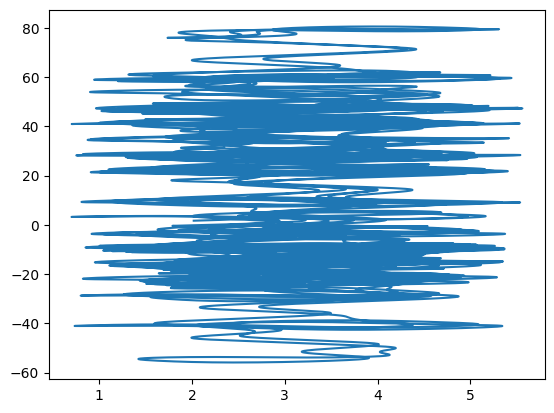

In [6]:
"""Generate and print our data."""

# Make our time array:
tsteps = jnp.linspace(0, total_time, data_points)

init = generate_initial_point(False)
generated_data = odeint(dy_dt, init, tsteps, g)
plt.plot(generated_data[:, 0], generated_data[:, 1])

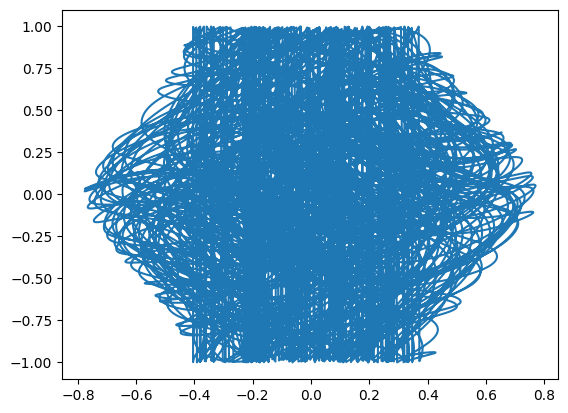

In [7]:
"""Normalise and print our generated data."""

# Normalise the angles by dividing by pi, and the velocity by dividing by 100.
@jit
def modulo_two_pi(x):
  return x % (2 * pi)

# Normalise our generated data. We normalise the angles by modulo-ing the angles by 2 pi, dividing by pi (so that values are between 0 and 2), and then subtracting 1,
# so that the valeus are between -1 and 1. To normalise the angular velocities, divide by 100.
@jit
def normalise_data(generated_data):
  normalised_data = generated_data
  normalised_data = normalised_data.at[:,:2].apply(modulo_two_pi)
  normalised_data = normalised_data.at[:,:2].divide(pi)
  normalised_data = normalised_data.at[:,:2].add(-1)

  normalised_data = normalised_data.at[:,2:].divide(pi)

  return normalised_data

normalised_data = normalise_data(generated_data)
plt.plot(normalised_data[:, 0], normalised_data[:, 1])

# Before we split the data, we need to actually package it into short ordered batches. The idea is we will have:
# the dataset: [y0, y1, .... , yt], where yi = (theta_1i, theta_2i, omega_1i, omega_2i)
# which will then be packaged into smaller, ordered time series batches like this:
# z0 = [y0, y1, ... , yn], z1 = [y(n+1), y(n+2), ... , y(2n)] etc.
# And these can then be put into training batches as we would expect normally.

ordered_batches = []

for i in range(data_points - prediction_batch_size - 1):
  ordered_batches.append(normalised_data[i:i + prediction_batch_size,:])

ordered_batches = jnp.array(ordered_batches)
# Split the data. We need shuffle to be 0 to preserve the time series.
x_train, x_test = train_test_split(ordered_batches, random_state=42)



# Build The Model

In [8]:
"""Define our dataset class. This allows us to batch our data when training."""

class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""
  # Initialise our dataset class. It needs the full x and y values and a batch size to be initialised.
  def __init__(self, x: jnp.array, batch_size: int):
    self._x = x
    self._batch_size = batch_size
    self._length = self._x.shape[0]
    # The id stores where the next datapoint should be taken from, so when initialised it should be 0.
    self._idx = 0

  # This is the function that gives us our next batch of data.
  def __next__(self):
    # Start again from beginning of dataset if there are not enough datapoints in front.
    if self._idx + self._batch_size >= self._length:
      self._idx = 0

    # Select the first and last datapoints in the batch. First will be the current value of the ID
    start = self._idx
    end = start + self._batch_size
    # Select our data.
    x= self._x[start:end]
    # This resets us back to 0 once we reach the end of our data.
    if end >= self._length:
      end = end % self._length
      # assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end
    return x

In [9]:
"""Now that we have defined our dataset class, we can make our datasets."""

train_dataset = Dataset(x_train, training_batch_size)
eval_dataset = Dataset(x_test, training_batch_size)

In [10]:
"""Define our batch and trainingstate class."""

# Define a batch of data.
class Batch(NamedTuple):
  input: np.ndarray
  output: np.ndarray

# Define a training state, telling us what parameters we have and the state of the optimizer.
class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

In [21]:
"""Define the neural network and set our optimizer."""

def FeedForward(x):
  mlp = hk.Sequential([
      hk.Linear(32), jax.nn.relu,
      hk.Linear(32), jax.nn.relu,
      hk.Linear(32), jax.nn.relu,
      hk.Linear(2),
  ])
  return mlp(x)

# Define our network and optimiser.
network = hk.without_apply_rng(hk.transform(FeedForward))
optimiser = optax.adam(1e-2)

In [22]:
"""Define our mean squared error loss function."""

@jit
def nn_predict(x, t, weights):
  # Our network only predicts the acceleration. Since we are using odeint on it, we need input and output to be the same shape, so we can attach the velocities directly
  # onto it too.
  veloc = x[2:]
  x_tanh = x.at[2:].apply(jnp.tanh)
  accel = network.apply(weights, x_tanh)
  # accel = jnp.arctanh(accel)
  y = jnp.hstack((veloc, accel))
  return y

@jit
def modulo_two(x):
  return x % 2

@jit
def normalise_predictions(preds):
  preds = preds.at[:,:2].add(1)
  preds = preds.at[:,:2].apply(modulo_two)
  preds = preds.at[:,:2].add(-1)
  return preds


@jit
def MeanSquaredErrorLoss(weights, batch):
  # WLOG, we can set each time series as starting from 0.
  tsteps = jnp.array([i*dt for i in range(prediction_batch_size)])
  # This array will hold our predictions for each prediction batch.
  preds = []
  # Make our predictions. Our output data is periodic between (-1, 1), but odeint doesn't know that it has to stay within these bounds. Thus,
  # we will have to manually normalise it. To do this, we can add 1 so it is periodic between (0, 2), module by 2, and then subtract 1 again.
  for i in range(training_batch_size):
    prediction = odeint(nn_predict, batch[i, 0], tsteps, weights)
    prediction = normalise_predictions(prediction)
    # This adds the prediction for batch i to the preds tuple.
    preds.append(prediction)

  preds = jnp.array(preds)

  return jnp.power(batch - preds, 2).mean()

In [23]:
"""Define what happens at each gradient update."""

@jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  # This is how we define our stochastic gradient descent.

  # Find grads of loss w.r.t parameters, on this batch of the data
  grads = jax.grad(MeanSquaredErrorLoss)(state.params, batch)
  # Get the updates and the new optimser state from this.
  updates, opt_state = optimiser.update(grads, state.opt_state)
  # Apply the updates to the parameters.
  params = optax.apply_updates(state.params, updates)

  #return the training state with the new parameters and the optimiser.
  return TrainingState(params, opt_state)

In [24]:
"""Initialise our parameters and print the shape of our network."""

 #Initialising the parameters randomly.
rng = jax.random.PRNGKey(12)
initial_params = network.init(rng, x_train[1])

# Initialise the optimiser and the define the state.
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

# Print the structure of the network.
print("Weights Type : {}\n".format(type(initial_params)))

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape,initial_params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

linear
Weights : (4, 32), Biases : (32,)

linear_1
Weights : (32, 32), Biases : (32,)

linear_2
Weights : (32, 32), Biases : (32,)

linear_3
Weights : (32, 2), Biases : (2,)



In [25]:
"""Define lists to store our loss over time in. This is not in the cell below so that we can run our training loop multiple times and keep the losses."""

train_loss_list = []
val_loss_list = []

In [ ]:
"""Run the training & evaluation loop."""

for step in range(gradient_updates):
  # Do stochastic gradient descent on a batch of training examples.
  state = update(state, next(train_dataset))

  # Print the training and evaluation loss every 1000 time steps. We normalise the loss so that if we change batch size, the loss stays at the same scale.

  if step % 100 == 0:
    train_loss_list.append(MeanSquaredErrorLoss(state.params, next(train_dataset)) / (training_batch_size * prediction_batch_size))
    val_loss_list.append(MeanSquaredErrorLoss(state.params, next(eval_dataset)) / (training_batch_size * prediction_batch_size))
    print("Step {}: train loss {}, eval loss {}".format(step, train_loss_list[-1], val_loss_list[-1]))

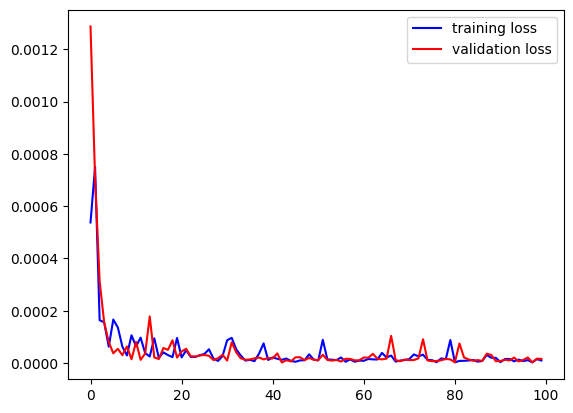

In [27]:
"""Plot our losses"""

plt.plot(train_loss_list, color="b", label="training loss")
plt.plot(val_loss_list, color="red", label="validation loss")
plt.legend()

total dataset loss:  nan


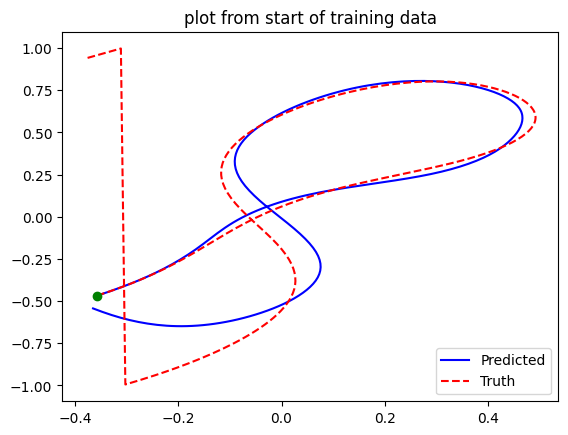

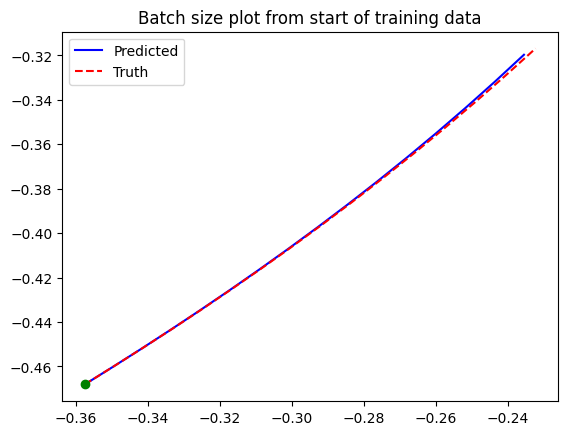

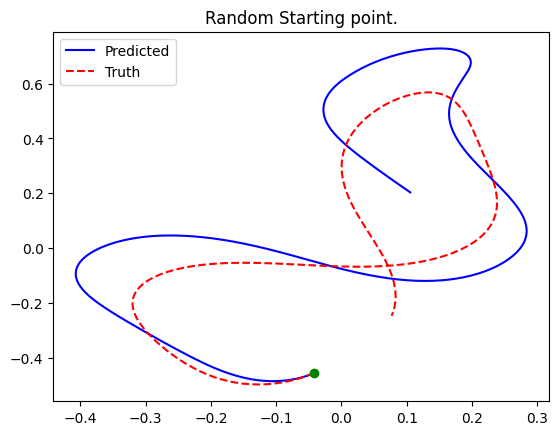

In [32]:
"""Create graphs showing how well our model does, and evaluate loss from each of these graphs."""

# How many points to print / generate for our graphs.
display_data_points = 256

# Our first graph will be comparing the full length of training data to predictions of this.
predicted_data = odeint(nn_predict, normalised_data[0], tsteps, state.params)
predicted_data = normalise_predictions(predicted_data)

# Print the loss on this full length of the dataset.
print("total dataset loss: ", jnp.power(normalised_data[:,:2] - predicted_data[:,:2], 2).mean())

# The graph looks very messy if the number of points is large, so we only print the first display_data_points of the data.
plt.plot(predicted_data[:display_data_points, 0], predicted_data[:display_data_points, 1], color="blue", label="Predicted")
plt.plot(normalised_data[:display_data_points, 0], normalised_data[:display_data_points, 1], color="red", label="Truth", linestyle="dashed")
plt.plot(normalised_data[0,0], normalised_data[0,1], "o", color="green")
plt.legend()
plt.title("plot from start of training data")
plt.show()
plt.close()

# The second graph will be using the same generated data, but only displaying as many points as are in the prediction batches.
plt.plot(predicted_data[:prediction_batch_size, 0], predicted_data[:prediction_batch_size, 1], color="blue", label="Predicted")
plt.plot(normalised_data[:prediction_batch_size, 0], normalised_data[:prediction_batch_size, 1], color="red", label="Truth", linestyle="dashed")
plt.plot(normalised_data[0,0], normalised_data[0,1], "o", color="green")
plt.legend()
plt.title("Batch size plot from start of training data")
plt.show()
plt.close()

# The final graph will be from a newly generated set of data.

# Generate our initial datapoints and normalise these.
init_eval = generate_initial_point(False, perturb=0.1)
generated_eval_data = odeint(dy_dt, init_eval, tsteps, g)
normalised_eval_data = normalise_data(generated_eval_data)

# Use our network to make predictions on this and normalise those.
predicted_eval_data = odeint(nn_predict, normalised_eval_data[0], tsteps, state.params)
predicted_eval_data = normalise_predictions(predicted_eval_data)

# Plot this data
plt.plot(predicted_eval_data[:display_data_points, 0], predicted_eval_data[:display_data_points, 1], color="blue", label="Predicted")
plt.plot(normalised_eval_data[:display_data_points, 0], normalised_eval_data[:display_data_points, 1], color="red", label="Truth", linestyle="dashed")
plt.plot(normalised_eval_data[0,0], normalised_eval_data[0,1], "o", color="green")
plt.legend()
plt.title("Random Starting point.")
plt.show()
plt.close()

# Create animation of the pendulums

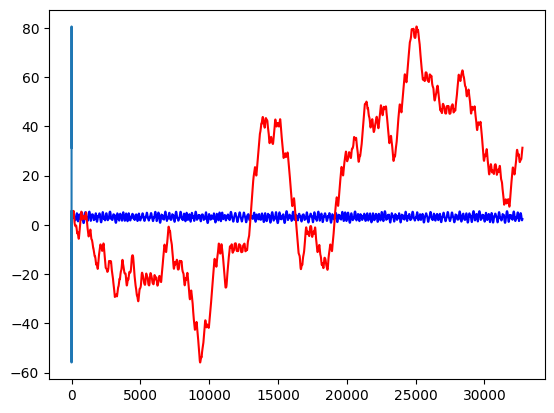

In [33]:
 # Computes a plot of the angles.
theta_1 = generated_data[:, 0]
theta_2 = generated_data[:, 1]


plt.plot(theta_1, c='b')
plt.plot(theta_2, c='r')

plt.plot(theta_1, theta_2)

Code below will convert the data into a gif.

0 / 3276
1 / 3276
2 / 3276
3 / 3276
4 / 3276
5 / 3276
6 / 3276
7 / 3276
8 / 3276
9 / 3276
10 / 3276
11 / 3276
12 / 3276
13 / 3276
14 / 3276
15 / 3276
16 / 3276
17 / 3276
18 / 3276
19 / 3276
20 / 3276
21 / 3276
22 / 3276
23 / 3276
24 / 3276
25 / 3276
26 / 3276
27 / 3276
28 / 3276
29 / 3276
30 / 3276
31 / 3276
32 / 3276
33 / 3276
34 / 3276
35 / 3276
36 / 3276
37 / 3276
38 / 3276
39 / 3276
40 / 3276
41 / 3276
42 / 3276
43 / 3276
44 / 3276
45 / 3276
46 / 3276
47 / 3276
48 / 3276
49 / 3276
50 / 3276
51 / 3276
52 / 3276
53 / 3276
54 / 3276
55 / 3276
56 / 3276
57 / 3276
58 / 3276
59 / 3276
60 / 3276
61 / 3276
62 / 3276
63 / 3276
64 / 3276
65 / 3276
66 / 3276
67 / 3276
68 / 3276
69 / 3276
70 / 3276
71 / 3276
72 / 3276
73 / 3276
74 / 3276
75 / 3276
76 / 3276
77 / 3276
78 / 3276
79 / 3276
80 / 3276
81 / 3276
82 / 3276
83 / 3276
84 / 3276
85 / 3276
86 / 3276
87 / 3276
88 / 3276
89 / 3276
90 / 3276
91 / 3276
92 / 3276
93 / 3276
94 / 3276
95 / 3276
96 / 3276
97 / 3276
98 / 3276
99 / 3276
100 / 3276

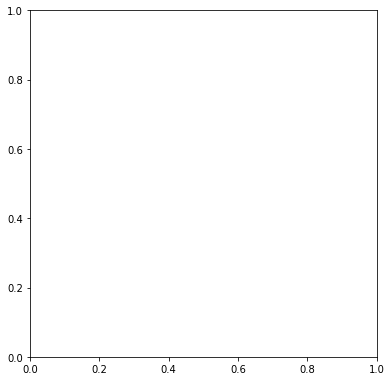

In [37]:
# Convert to Cartesian coordinates of the two bob positions.

theta_1 = (1 + predicted_data[:,0]) * pi
theta_2 = (1 + predicted_data[:,1]) * pi

Theta_1 = generated_data[:,0]
Theta_2 = generated_data[:,1]

x1 = sin(theta_1)
y1 = cos(theta_1)
x2 = x1 + sin(theta_2)
y2 = y1 + cos(theta_2)

X1 = sin(Theta_1)
Y1 = cos(Theta_1)
X2 = X1 + sin(Theta_2)
Y2 = Y1 + cos(Theta_2)

# Plotted bob circle radius
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

def make_plot(i):
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    ax.plot([0, X1[i], X2[i]], [0, Y1[i], Y2[i]], lw=2, c='k')
    c3 = Circle((X1[i], Y1[i]), r, fc='g', ec='g', zorder=10)
    c4 = Circle((X2[i], Y2[i]), r, fc='y', ec='y', zorder=10)
    ax.add_patch(c3)
    ax.add_patch(c4)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

        ax.plot(X2[imin:imax], Y2[imin:imax], c='y', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-2-r, 2+r)
    ax.set_ylim(-2-r, 2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('img{:04d}.png'.format(i//di), dpi=72)
    plt.plot()
    plt.cla()


# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
fps = 10
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

for i in range(0, tsteps.size, di):
    print(i // di, '/', tsteps.size // di)
    make_plot(i)

In [38]:
frames = []
for i in range(int(tsteps.size) // di):
  image = imageio.v2.imread(f'img{i:04}.png')
  frames.append(image)

imageio
imageio.mimsave('./example.gif', # output gif
                frames,          # array of input frames
                fps = 10)         # optional: frames per second """

